In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2025-05-11 14:30:01.478739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746973801.501554  279805 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746973801.508648  279805 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
image_path = '/kaggle/input/microsoft-coco-2017-common-objects-in-context/train2017'

In [5]:
import os

image_path = '/kaggle/input/microsoft-coco-2017-common-objects-in-context/train2017'

# Get the list of files in the directory
file_list = os.listdir(image_path)

# Count the number of images
num_images = len(file_list)
print(f"Number of images in train2017: {num_images}")

Number of images in train2017: 118287


In [6]:
import json

# Open the captions_train2017.json file
with open('/kaggle/input/microsoft-coco-2017-common-objects-in-context/annotations_trainval2017/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']
# Check the number of captions
num_captions = len(data)
print(f"Number of captions in captions_train2017: {num_captions}")

Number of captions in captions_train2017: 591753


In [7]:
img_cap_pairs = []

# Iterate over each annotation in the data
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([img_name, sample['caption']])

# Create a DataFrame from the image-caption pairs
data = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

# Format the image paths
data['image'] = data['image'].apply(
    lambda x: f'{image_path}/{x}'
)

# Sample 40,000 captions
data = data.sample(40000)

# Reset the DataFrame index
data = data.reset_index(drop=True)

# Print the first few rows of the DataFrame
data.head()  

image  \
0  /kaggle/input/microsoft-coco-2017-common-objec...   
1  /kaggle/input/microsoft-coco-2017-common-objec...   
2  /kaggle/input/microsoft-coco-2017-common-objec...   
3  /kaggle/input/microsoft-coco-2017-common-objec...   
4  /kaggle/input/microsoft-coco-2017-common-objec...   

                                             caption  
0  A large group of scissors placed next to each ...  
1       Two women talking in front of several horses  
2            The street sign is next to a full tree.  
3  A man sitting on a ships mooring anchor at the...  
4  a woman with eye glasses holding a cell phone ...

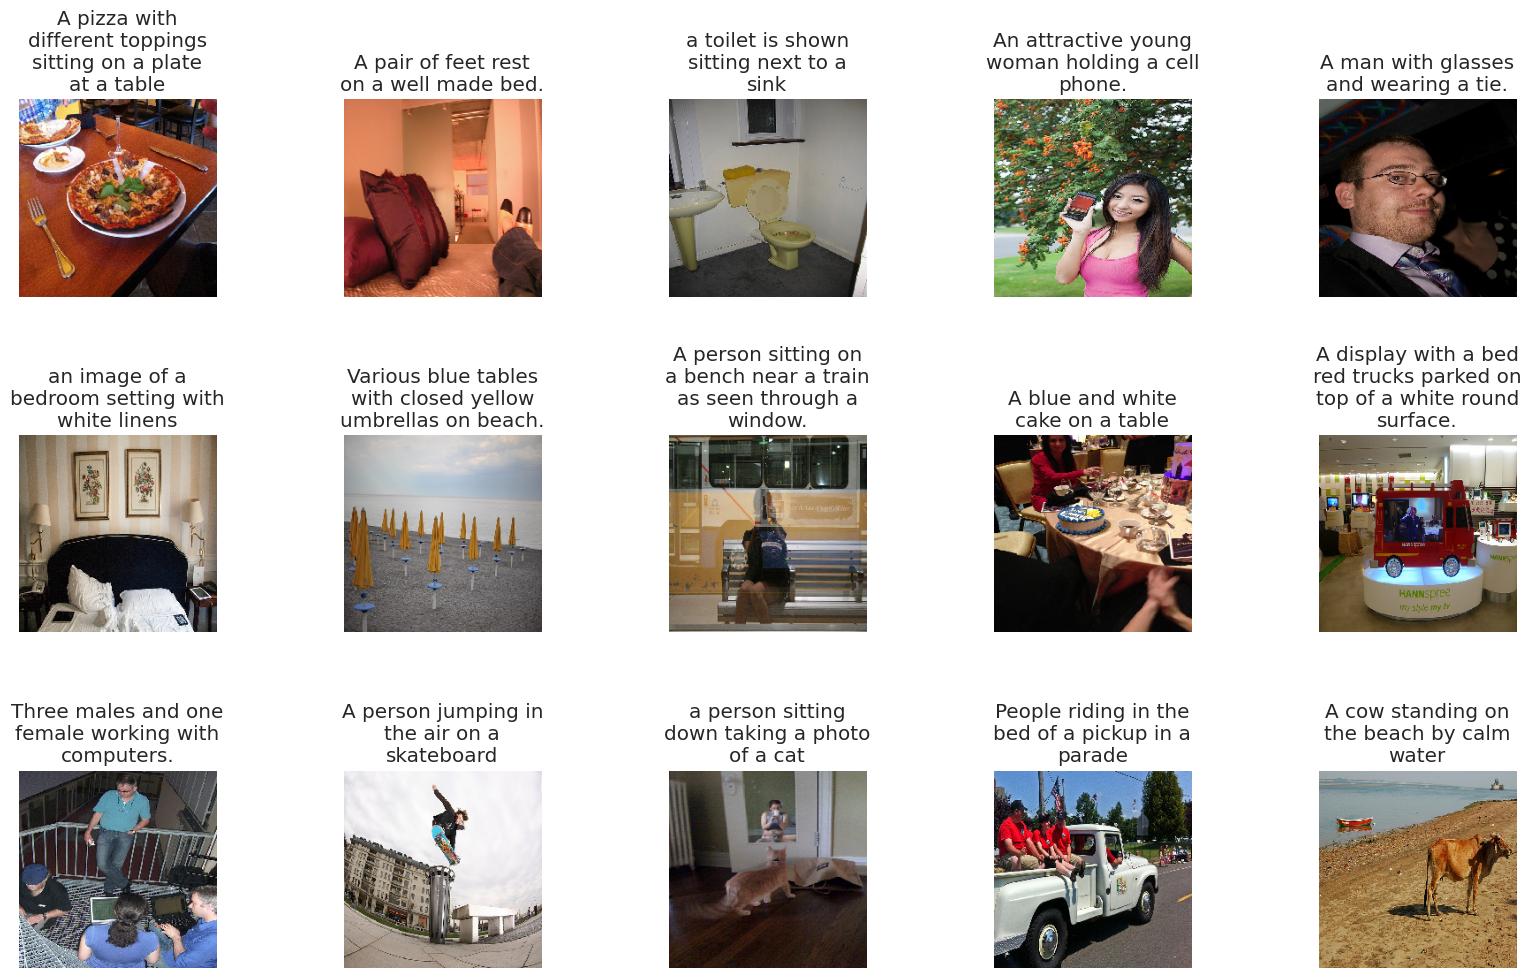

In [8]:
def readImage(path, img_size=224):
    # Construct the full image path by joining the base directory path with the image filename
    img_path = os.path.join('/kaggle/input/microsoft-coco-2017-common-objects-in-context/train2017', os.path.basename(path))
    
    # Load the image, convert it to an array, and normalize the pixel values
    img = load_img(img_path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0

    return img

def display_images(temp_df):
    # Reset the index of the DataFrame
    temp_df = temp_df.reset_index(drop=True)
    
    # Create a figure with a specified size
    plt.figure(figsize=(20, 20))
    
    n = 0
    for i in range(15):
        n += 1
        
        # Create a subplot and adjust the spacing between subplots
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        
        # Load and display the image
        image = readImage(f"/kaggle/input/microsoft-coco-2017-common-objects-in-context/train2017/{temp_df.image[i]}")
        plt.imshow(image)
        
        # Wrap the caption text to a maximum of 20 characters per line and set it as the title of the subplot
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        
        # Turn off the axis
        plt.axis("off")

# Call the display_images() function with a sample of 15 rows from the 'captions' DataFrame
display_images(data.sample(15))

In [9]:
import re
def text_preprocessing(data):
    # Convert captions to lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    
    # Remove non-alphabetic characters
    data['caption'] = data['caption'].apply(lambda x: re.sub("[^A-Za-z]", " ", x))
    
    # Replace multiple whitespaces with a single whitespace
    data['caption'] = data['caption'].apply(lambda x: re.sub("\s+", " ", x))
    
    # Remove words with length less than or equal to 1
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    
    # Add start and end tokens to captions
    data['caption'] = "startseq " + data['caption'] + " endseq"
    
    return data

In [10]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq large group of scissors placed next to each other endseq',
 'startseq two women talking in front of several horses endseq',
 'startseq the street sign is next to full tree endseq',
 'startseq man sitting on ships mooring anchor at the dock endseq',
 'startseq woman with eye glasses holding cell phone to her head endseq',
 'startseq the people are skiing down the hill together endseq',
 'startseq various equine horses and zebras inside stalls under tent endseq',
 'startseq large white plane sits on run way endseq',
 'startseq train pulling passenger cars going around curve endseq',
 'startseq man on tennis court with his racket raised up endseq']

In [11]:
# Create a tokenizer and fit it on the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

# Determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Find the maximum caption length
max_length = max(len(caption.split()) for caption in captions)

# Get the unique image names
images = data['image'].unique().tolist()
nimages = len(images)

# Split the images into train and test sets
split_index = round(0.85 * nimages)
train_images = images[:split_index]
test_images = images[split_index:]

# Create train and test dataframes
train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(test_images)].reset_index(drop=True)

# Convert a caption to a sequence of integers using the tokenizer
sample_caption = captions[1]
sequence = tokenizer.texts_to_sequences([sample_caption])[0]

# Print the resulting sequence
print(sequence)

[1, 13, 176, 319, 6, 40, 4, 93, 182, 2]


In [12]:
# Create a DenseNet201 model
model = DenseNet201()

# Create a feature extraction model by taking the output from the second last layer of the DenseNet201 model
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Set the image size
img_size = 224

# Create a dictionary to store the image features
features = {}

# Iterate over the unique image paths in your COCO dataset
for image in tqdm(data['image'].unique().tolist()):
    # Construct the image path by joining the base directory with the image name
    img_path = os.path.join('/kaggle/input/microsoft-coco-2017-common-objects-in-context/train2017', os.path.basename(image))
    
    # Load and preprocess the image using load_img and img_to_array functions
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    
    # Normalize the image pixel values to the range of [0, 1]
    img = img / 255.0
    
    # Expand the dimensions of the image array to match the model's input shape
    img = np.expand_dims(img, axis=0)
    
    # Extract the features by passing the preprocessed image through the feature extraction model (fe) using the predict method
    feature = fe.predict(img, verbose=0)
    
    # Store the extracted features in a dictionary with the image path as the key
    features[image] = feature

I0000 00:00:1746973810.344533  279805 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
  0%|          | 0/34923 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746973823.005422  279859 service.cc:148] XLA service 0x7e78fc0022f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746973823.005478  279859 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746973825.015109  279859 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746973836.768844  279859 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 34923/34923 [51:52<00:00, 11.22it/s] 


In [13]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()  # Create a copy of the dataframe
        self.X_col = X_col  # Column name for image filenames
        self.y_col = y_col  # Column name for captions
        self.directory = directory  # Directory where images are located
        self.batch_size = batch_size  # Batch size
        self.tokenizer = tokenizer  # Tokenizer object
        self.vocab_size = vocab_size  # Vocabulary size
        self.max_length = max_length  # Maximum caption length
        self.features = features  # Dictionary of image features
        self.shuffle = shuffle  # Shuffle flag
        self.n = len(self.df)  # Number of samples in the dataframe
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
    
    def __len__(self):
        return self.n // self.batch_size  # Compute the number of batches
    
    def __getitem__(self, index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)  # Get data for the current batch      
        return (X1, X2), y
    
    def __get_data(self, batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image]
            feature = np.reshape(feature, (1920,))  # Reshape image feature
            
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y

In [14]:
from PIL import Image

# Open the image
image = Image.open("/kaggle/input/microsoft-coco-2017-common-objects-in-context/train2017/000000000009.jpg")

# Get the size of the image
width, height = image.size
print("Image size:", width, "x", height)

Image size: 640 x 480


In [15]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
from tensorflow.keras.utils import plot_model

In [17]:
# Create a custom data generator for training data
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory='image_path',
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

# Create a custom data generator for validation data
validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory='image_path',
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

In [18]:
model_name = "model.keras"

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# Early stopping to stop training if validation loss does not improve after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Learning rate reduction to reduce learning rate if validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

In [19]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [20]:
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = caption_model.fit(
    train_generator,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]  # List of callback functions
)

Epoch 1/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1320 - loss: 5.8138
Epoch 1: val_loss improved from inf to 4.43104, saving model to model.keras
541/541 ━━━━━━━━━━━━━━━━━━━━ 136s 245ms/step - accuracy: 0.1320 - loss: 5.8127 - val_accuracy: 0.2451 - val_loss: 4.4310 - learning_rate: 0.0010
Epoch 2/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2425 - loss: 4.4677
Epoch 2: val_loss improved from 4.43104 to 4.08132, saving model to model.keras
541/541 ━━━━━━━━━━━━━━━━━━━━ 134s 246ms/step - accuracy: 0.2425 - loss: 4.4676 - val_accuracy: 0.2854 - val_loss: 4.0813 - learning_rate: 0.0010
Epoch 3/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2708 - loss: 4.1370
Epoch 3: val_loss improved from 4.08132 to 3.91757, saving model to model.keras
541/541 ━━━━━━━━━━━━━━━━━━━━ 133s 245ms/step - accuracy: 0.2708 - loss: 4.1370 - val_accuracy: 0.3021 - val_loss: 3.9176 - learning_rate: 0.0010
Epoch 4/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy:

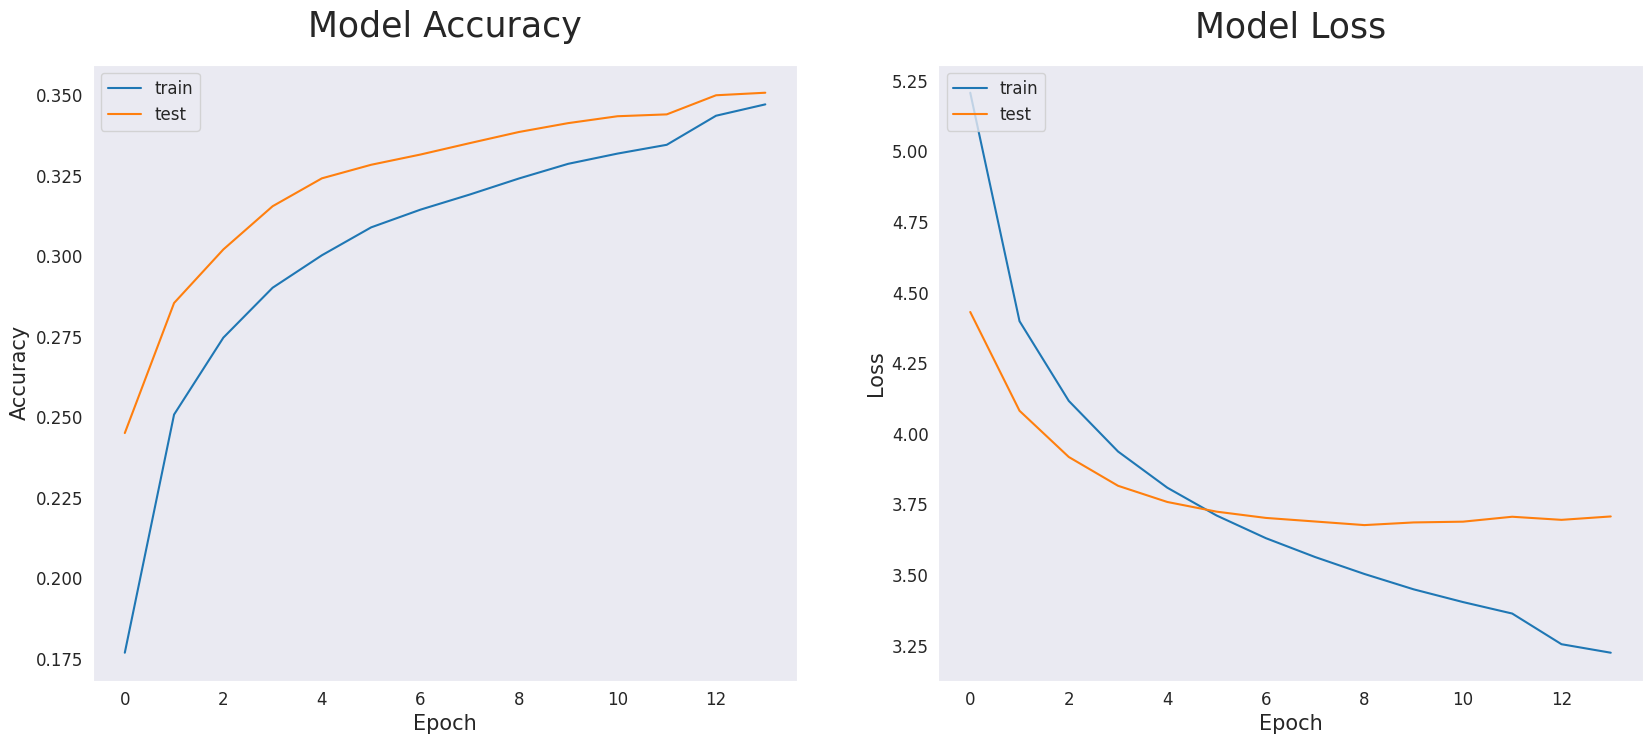

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=[20, 8])

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'A])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [22]:
def idx_to_word(integer,tokenizer):
    
    for word, index Ain tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [23]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [24]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [25]:
for index,record in samples.iterrows():
    
    img = load_img(record['image'], target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [26]:
image_path = '/kaggle/input/microsoft-coco-2017-common-objects-in-context/train2017'

for index, record in samples.iterrows():
    img_filename = os.path.basename(record['image'])
    img_path = os.path.join(image_path, img_filename)

    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index, 'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

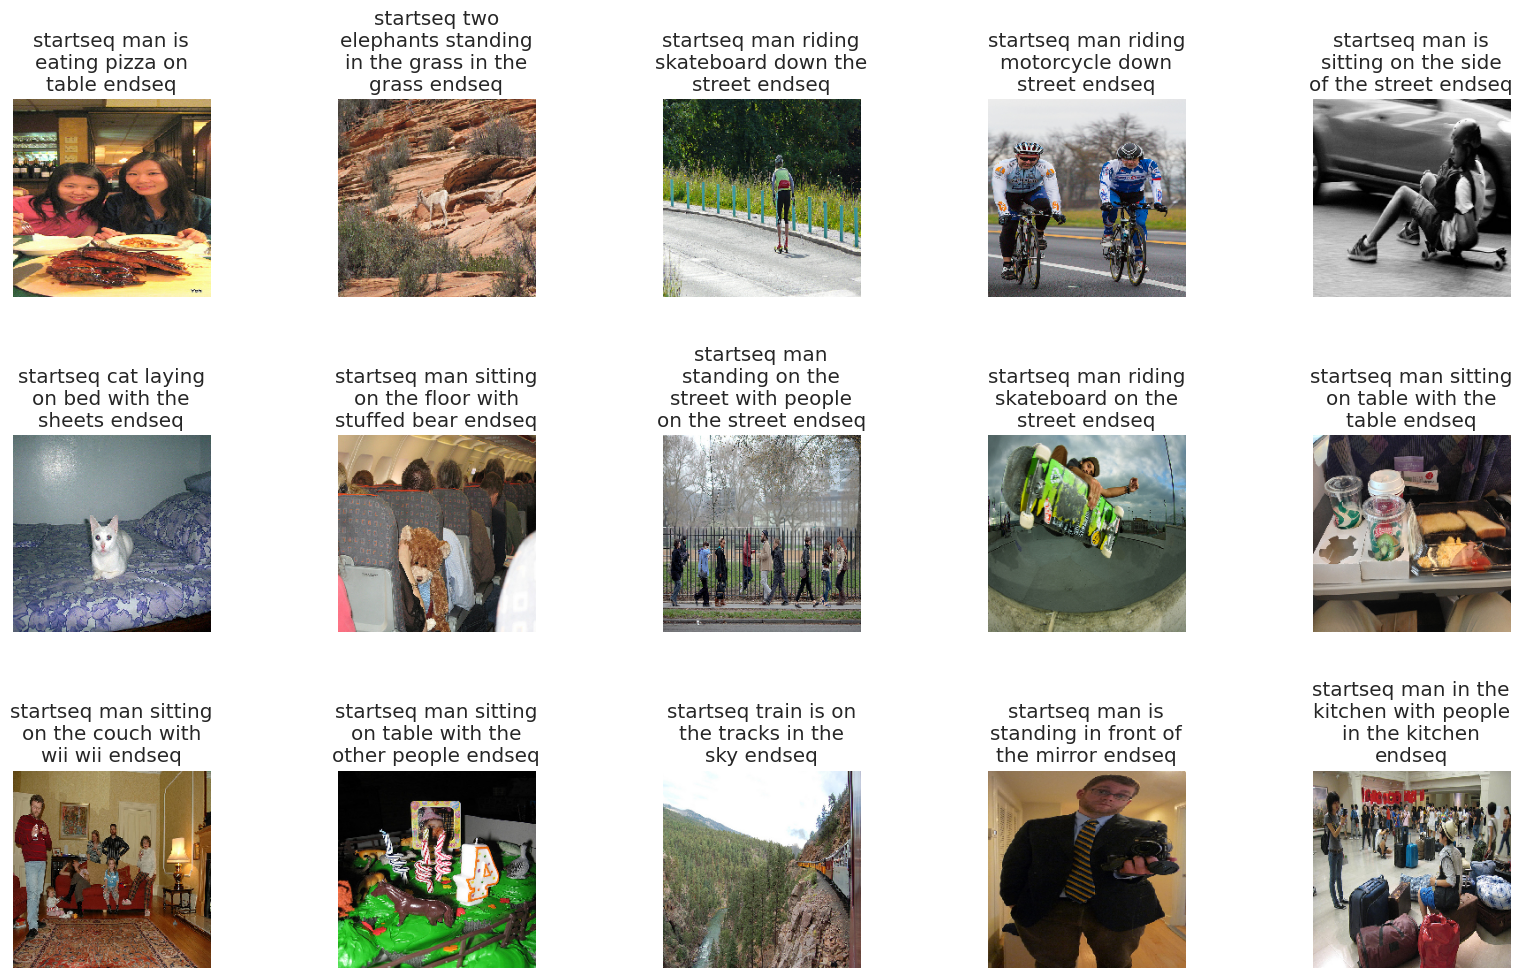

In [27]:
display_images(samples)

In [28]:
def predict_caption(model, image_path, tokenizer, max_length, features_extractor):
    # Load and preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Extract features using DenseNet201 feature extractor
    feature = features_extractor.predict(img, verbose=0)
    feature = np.reshape(feature, (1920,))

    # Generate caption
    caption = 'startseq'
    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([caption])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([np.array([feature]), seq], verbose=0)
        yhat = np.argmax(yhat)

        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        caption += ' ' + word
        if word == 'endseq':
            break

    # Remove startseq and endseq
    final_caption = caption.replace('startseq', '').replace('endseq', '').strip()
    return final_caption

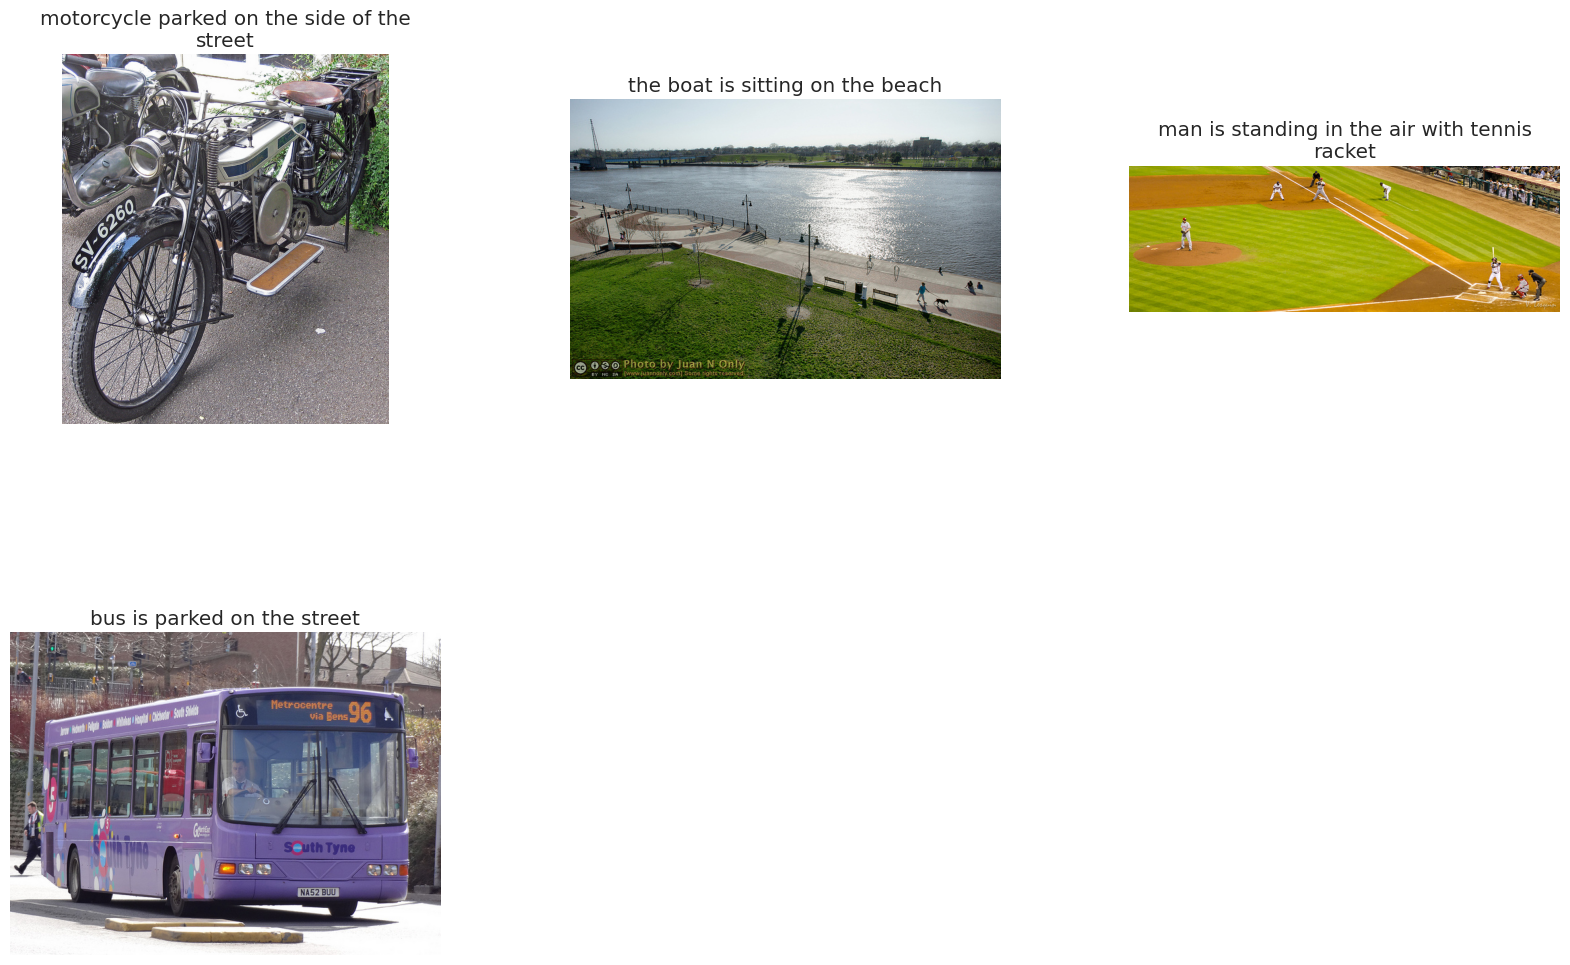

In [29]:
from matplotlib import pyplot as plt
from textwrap import wrap

# List of image filenames from the dataset
custom_images = [
    '/kaggle/input/testing/000000000073.jpg',
    '/kaggle/input/testing/000000000109.jpg',
    '/kaggle/input/testing/000000000357.jpg',
    '/kaggle/input/testing/000000002006.jpg',
]

# Set up the plot
plt.figure(figsize=(20, 12))
n = 0

for image_path in custom_images:
    n += 1
    plt.subplot(2, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # Generate caption
    caption = predict_caption(caption_model, image_path, tokenizer, max_length, fe)
    
    # Display image
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title("\n".join(wrap(caption, 40)))

plt.show()

In [30]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=0b037b2aabb13a3767be2c404b5d48b42e9feecca24ae95c90e7c5968f7ca326
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [31]:
import json
from collections import defaultdict
import os

# File paths
captions_path = '/kaggle/input/microsoft-coco-2017-common-objects-in-context/annotations_trainval2017/captions_train2017.json'
images_dir = '/kaggle/input/microsoft-coco-2017-common-objects-in-context/train2017'

# Your predictions and subset image IDs
subset_image_ids = [391895, 522418, 184613, 318219]
predictions = ["a man riding a bike", "a cat on the table", "a dog running", "people standing"]

# Step 1: Load the JSON annotations
with open(captions_path, 'r') as f:
    coco_data = json.load(f)

# Step 2: Build mappings
# Map: image_id -> list of captions
imageid_to_captions = defaultdict(list)
for ann in coco_data['annotations']:
    imageid_to_captions[ann['image_id']].append(ann['caption'])

# Map: image_id -> file_name (optional if you want to display the image)
imageid_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}

# Step 3: Extract references and hypotheses
references = []
hypotheses = []
image_filenames = []

for image_id, pred in zip(subset_image_ids, predictions):
    ref_captions = imageid_to_captions[image_id]
    ref_tokens = [caption.lower().strip().split() for caption in ref_captions]
    pred_tokens = pred.lower().strip().split()

    references.append(ref_tokens)
    hypotheses.append(pred_tokens)
    image_filenames.append(imageid_to_filename[image_id])

# ✅ Now you have:
# - references: tokenized ground truth captions
# - hypotheses: tokenized predicted captions
# - image_filenames: optional image names to load/display images

# Example: print sample alignment
for fname, refs, hypo in zip(image_filenames, references, hypotheses):
    print(f"Image: {fname}")
    print("References:", [" ".join(ref) for ref in refs])
    print("Prediction:", " ".join(hypo))
    print("-" * 40)

Image: 000000391895.jpg
References: ['a man with a red helmet on a small moped on a dirt road.', 'man riding a motor bike on a dirt road on the countryside.', 'a man riding on the back of a motorcycle.', 'a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains.', 'a man in a red shirt and a red hat is on a motorcycle on a hill side.']
Prediction: a man riding a bike
----------------------------------------
Image: 000000522418.jpg
References: ['a woman wearing a net on her head cutting a cake.', 'a woman cutting a large white sheet cake.', 'a woman wearing a hair net cutting a large sheet cake.', 'there is a woman that is cutting a white cake', "a woman marking a cake with the back of a chef's knife."]
Prediction: a cat on the table
----------------------------------------
Image: 000000184613.jpg
References: ['a child holding a flowered umbrella and petting a yak.', 'a young man holding an umbre

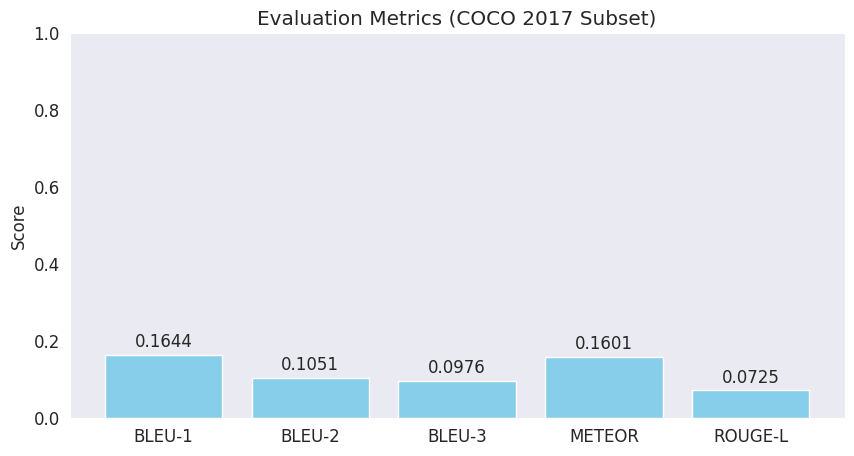


Evaluation Scores:
BLEU-1: 0.1644
BLEU-2: 0.1051
BLEU-3: 0.0976
METEOR: 0.1601
ROUGE-L: 0.0725


In [40]:
import json
from collections import defaultdict
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

# Load COCO captions
captions_path = '/kaggle/input/microsoft-coco-2017-common-objects-in-context/annotations_trainval2017/captions_train2017.json'

with open(captions_path, 'r') as f:
    coco_data = json.load(f)

# Sample image IDs and predictions
subset_image_ids = [391895, 522418, 184613, 318219]
predictions = ["a man riding a bike", "a cat on the table", "a dog running", "people standing"]

# Build reference captions
imageid_to_captions = defaultdict(list)
for ann in coco_data['annotations']:
    imageid_to_captions[ann['image_id']].append(ann['caption'])

# Tokenize for BLEU
references = []
hypotheses = []

# Store scores
meteor_scores = []
rouge_scores = []

# ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for image_id, pred in zip(subset_image_ids, predictions):
    refs = imageid_to_captions[image_id]
    
    # Tokenize
    tokenized_refs = [ref.lower().strip().split() for ref in refs]
    tokenized_pred = pred.lower().strip().split()
    
    # BLEU
    references.append(tokenized_refs)
    hypotheses.append(tokenized_pred)

    # METEOR
    meteor = meteor_score(tokenized_refs, tokenized_pred)
    meteor_scores.append(meteor)

    # ROUGE-L
    rouge = scorer.score(" ".join(refs), pred)['rougeL'].fmeasure
    rouge_scores.append(rouge)

# Compute scores (excluding BLEU-4)
bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(references, hypotheses, weights=(0.3, 0.3, 0.3, 0))
meteor = sum(meteor_scores) / len(meteor_scores)
rouge = sum(rouge_scores) / len(rouge_scores)

# Prepare for display (exclude BLEU-4)
metrics = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'METEOR', 'ROUGE-L']
values = [bleu1, bleu2, bleu3, meteor, rouge]

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(metrics, values, color='skyblue')
plt.ylabel('Score')
plt.title('Evaluation Metrics (COCO 2017 Subset)')
plt.ylim(0, 1)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f"{value:.4f}", ha='center', va='bottom')

plt.show()

# Print scores
print("\nEvaluation Scores:")
for metric, value in zip(metrics, values):
    print(f"{metric}: {value:.4f}")

In [33]:
import pickle

# Suppose your features dict is called `features`
with open('/kaggle/working/features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [34]:
with open('/kaggle/working/feature_images.txt', 'w') as f:
    for k in features.keys():
        f.write(f"{k}\n")

In [35]:
!pip install -q transformers

from transformers import pipeline, set_seed
import random

In [36]:
# Load GPT-2 or a larger model if desired (e.g., 'EleutherAI/gpt-neo-125M')
generator = pipeline('text-generation', model='gpt2')
set_seed(42)  # For reproducibility

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [57]:
from matplotlib import pyplot as plt
from keras.utils import load_img
import time

# Step 2: Load image paths
custom_images = [
    '/kaggle/input/testing/000000000073.jpg',
    '/kaggle/input/testing/000000000109.jpg',
    '/kaggle/input/testing/000000000357.jpg',
    '/kaggle/input/testing/000000002006.jpg',
]

captions = []

def clean_caption(raw_caption):
    cleaned = raw_caption.strip().capitalize().rstrip('.')
    if not cleaned.endswith('.'):
        cleaned += '.'
    return cleaned

# Step 3: Caption generation loop
print("🧠 Generating captions for input images...\n")
for i, image_path in enumerate(custom_images):
    raw_caption = predict_caption(caption_model, image_path, tokenizer, max_length, fe)
    caption = clean_caption(raw_caption)
    captions.append(caption)
    print(f"🖼️ Caption {i+1}: {caption}")

# Step 4: Combine captions for final prompt
combined_caption_input = " ".join(captions)
final_story_prompt = (
    "Here are descriptions of four images shown in a sequence:\n\n"
    f"{combined_caption_input}\n\n"
    "Using these, write a single, smooth story around 200 words long. "
    "Make the story coherent and natural. Don't list the captions or add any instructions.\n\n"
    "Story:"
)

final_story = generator(
    final_story_prompt,
    max_length=300,
    do_sample=False,
    temperature=0.7,
    repetition_penalty=1.3,
    num_return_sequences=1,
    pad_token_id=50256
)[0]['generated_text']

if final_story_prompt in final_story:
    final_story = final_story.replace(final_story_prompt, "").strip()

print("📨 GPT-2 Prompt Sent:")
print(final_story_prompt)
print("\n📖 Final Combined Story (200 words):\n")
print(final_story['generated_text'])

🧠 Generating captions for input images...

🖼️ Caption 1: Motorcycle parked on the side of the street.
🖼️ Caption 2: The boat is sitting on the beach.
🖼️ Caption 3: Man is standing in the air with tennis racket.
🖼️ Caption 4: Bus is parked on the street.
📨 GPT-2 Prompt Sent:
Here are descriptions of four images shown in a sequence:

Motorcycle parked on the side of the street. The boat is sitting on the beach. Man is standing in the air with tennis racket. Bus is parked on the street.

Using these, write a single, smooth story around 200 words long. Make the story coherent and natural. Don't list the captions or add any instructions.

Story:

📖 Final Combined Story (200 words):

It was a breezy afternoon in the coastal town, where the motorcycle was parked on the street, its engine still warm from a long ride along the cliffside highway. The rider, a traveler in search of quiet moments, had made his way toward the shore.

Down by the water, the boat was sitting on the beach with the wat

In [38]:
# Save model
model.save("image_captioning_model.h5")

# Download link (for Kaggle or Jupyter)
from IPython.display import FileLink
FileLink("image_captioning_model.h5")

/kaggle/working/image_captioning_model.h5

In [39]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)